# Preprocessing

Download data: Improt and unzip into a data folder

In [1]:
# !kaggle competitions download -c ieee-fraud-detection

In [2]:
# import zipfile
# with zipfile.ZipFile('ieee-fraud-detection.zip', 'r') as zip_ref:
#     zip_ref.extractall('data')

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, average_precision_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

## What we know about the data from discussion in Kaggle?


- TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
- TransactionAMT: transaction payment amount in USD
- ProductCD: product code, the product for each transaction
- card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
- addr: address
- dist: distance
- P_ and (R__) emaildomain: purchaser and recipient email domain
- C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
- D1-D15: timedelta, such as days between previous transaction, etc.
- M1-M9: match, such as names on card and address, etc.
- Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.


Turn to DataFrame

In [4]:
train_iden_df = pd.read_csv("data/train_identity.csv")
train_trans_df = pd.read_csv("data/train_transaction.csv")

In [5]:
print('Dimensions of the Train Identity set:',train_iden_df.shape)
print('Dimensions of the Train Transaction set:',train_trans_df.shape)

Dimensions of the Train Identity set: (144233, 41)
Dimensions of the Train Transaction set: (590540, 394)


In [6]:
print('All Transactions IDs from transaction dataset are in identity dataset: ', end= '')
if (np.sum(train_trans_df['TransactionID'].isin(train_iden_df['TransactionID'].unique())) - train_iden_df.shape[0]) == 0:
    print('True')
else:
    print('False')

All Transactions IDs from transaction dataset are in identity dataset: True


## Additional Analisys

### Explore columns data

In [7]:
train_df=pd.merge(train_trans_df,train_iden_df,how="left",on="TransactionID") # merge df by left
print("Train Dataset shape: ", train_df.shape)

Train Dataset shape:  (590540, 434)


In [8]:
columns_to_print = ['card1','card2','card3','card4','card5','card6']
values = train_df[columns_to_print]
print(values)

        card1  card2  card3       card4  card5   card6
0       13926    NaN  150.0    discover  142.0  credit
1        2755  404.0  150.0  mastercard  102.0  credit
2        4663  490.0  150.0        visa  166.0   debit
3       18132  567.0  150.0  mastercard  117.0   debit
4        4497  514.0  150.0  mastercard  102.0  credit
...       ...    ...    ...         ...    ...     ...
590535   6550    NaN  150.0        visa  226.0   debit
590536  10444  225.0  150.0  mastercard  224.0   debit
590537  12037  595.0  150.0  mastercard  224.0   debit
590538   7826  481.0  150.0  mastercard  224.0   debit
590539  15066  170.0  150.0  mastercard  102.0  credit

[590540 rows x 6 columns]


In [9]:
columns_address = ['C1', 'C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']
found_address = train_df[columns_address]
print(found_address)

         C1   C2   C3   C4   C5   C6   C7   C8   C9  C10  C11  C12   C13  C14
0       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  2.0  0.0   1.0  1.0
1       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0   1.0  1.0
2       1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
3       2.0  5.0  0.0  0.0  0.0  4.0  0.0  0.0  1.0  0.0  1.0  0.0  25.0  1.0
4       1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0   1.0  1.0
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...
590535  2.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  2.0  0.0  1.0  0.0   3.0  2.0
590536  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
590537  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0   1.0  1.0
590538  1.0  1.0  0.0  0.0  0.0  3.0  0.0  0.0  2.0  0.0  1.0  1.0   5.0  1.0
590539  2.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  2.0  0.0  1.0  0.0   1.0  1.0

[590540 rows x 14 columns]


In [10]:
columns_transaction_day = ['D1', 'D2','D3','D5','D15']
values_day = train_df[columns_transaction_day]
values_day

,D1,D2,D3,D5,D15
0,14.0,NaN,13.0,NaN,0.0
1,0.0,NaN,NaN,NaN,0.0
2,0.0,NaN,NaN,NaN,315.0
3,112.0,112.0,0.0,0.0,111.0
4,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...
590535,29.0,29.0,30.0,NaN,56.0
590536,0.0,NaN,NaN,NaN,0.0
590537,0.0,NaN,NaN,NaN,0.0
590538,22.0,22.0,0.0,0.0,22.0


In [11]:
columns_matchs = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
values_matchs = train_df[columns_matchs]
values_matchs

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,T,M2,F,T,NaN,NaN,NaN
1,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,T,T,T,M0,F,F,F,F,F
3,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
590535,T,T,T,M0,T,F,F,F,T
590536,T,F,F,M0,F,T,F,F,F
590537,T,F,F,NaN,NaN,T,NaN,NaN,NaN
590538,T,T,T,M0,F,T,NaN,NaN,NaN


### Explore class distribution

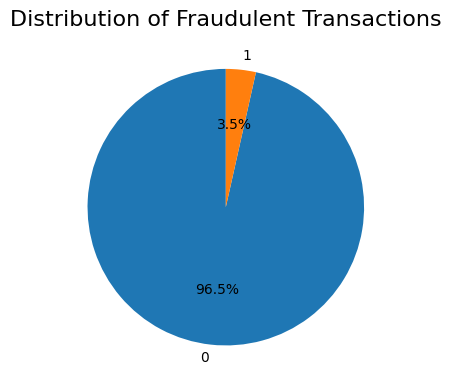

In [12]:
fraud_counts = train_df['isFraud'].value_counts()

plt.figure(figsize=(4, 4))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Fraudulent Transactions', fontsize=16)

plt.tight_layout()
plt.show()

## Dropping unnecessary columns

### Drop features if correlation between them is more than 90%

In [13]:
# Get categorical columns (excluding 'isFraud')
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
if 'isFraud' in categorical_cols:
    categorical_cols.remove('isFraud')

numerical_cols = [col for col in train_df.select_dtypes(include=['int64', 'float64']).columns 
                 if col not in categorical_cols]

In [14]:
corr_matrix = train_df[numerical_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

In [15]:
len(to_drop)

196

In [16]:
train_df.drop(columns=to_drop, axis=1, inplace=True)
train_df.shape

(590540, 238)

### Drop features if 99% of it's values are the same

In [17]:
from sklearn.feature_selection import VarianceThreshold

numerical_cols = [col for col in numerical_cols if col not in to_drop]

selector = VarianceThreshold(threshold=0.01)  # удаляем фичи с дисперсией < 1%
selector.fit(train_df[numerical_cols])
low_var_features = [col for col, var in zip(numerical_cols, selector.variances_) if var < 0.01]


In [18]:
len(low_var_features)

19

In [19]:
train_df.drop(columns=low_var_features, axis=1, inplace=True)
train_df.shape

(590540, 219)

### Get rid of numerical columns with close to 0 corelation with target

In [20]:
numerical_cols = [col for col in numerical_cols if col not in low_var_features]

# Calculate correlation with target
corr_with_target = train_df[numerical_cols].corr()[["isFraud"]].abs().sort_values("isFraud", ascending=False)

# Get low correlation features
low_corr_features = corr_with_target[corr_with_target["isFraud"] < 0.01].index.tolist()

In [21]:
len(low_corr_features)

32

In [22]:
train_df.drop(columns=low_corr_features, axis=1, inplace=True)
train_df.shape

(590540, 187)

## Get rid of Null values

### Explore the data further and deduce the best approach

How many collumns are useless and can be droped?

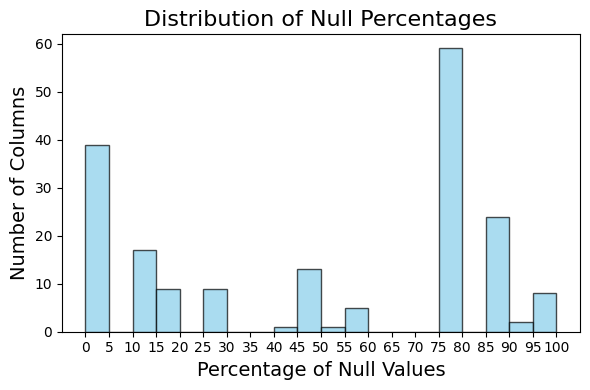

In [23]:
null_percentages = train_df.isnull().mean() * 100

# Create bins for null percentages (e.g., 0-5%, 6-10%, etc.)
bins = range(0, 101, 5)

plt.figure(figsize=(6, 4))
plt.hist(null_percentages, bins=bins, edgecolor='black', alpha=0.7, color='skyblue')

plt.title('Distribution of Null Percentages', fontsize=16)
plt.xlabel('Percentage of Null Values', fontsize=14)
plt.ylabel('Number of Columns', fontsize=14)
plt.xticks(bins) 

plt.tight_layout()
plt.show()

Are null values valuable for prediction or no? Show null values by class

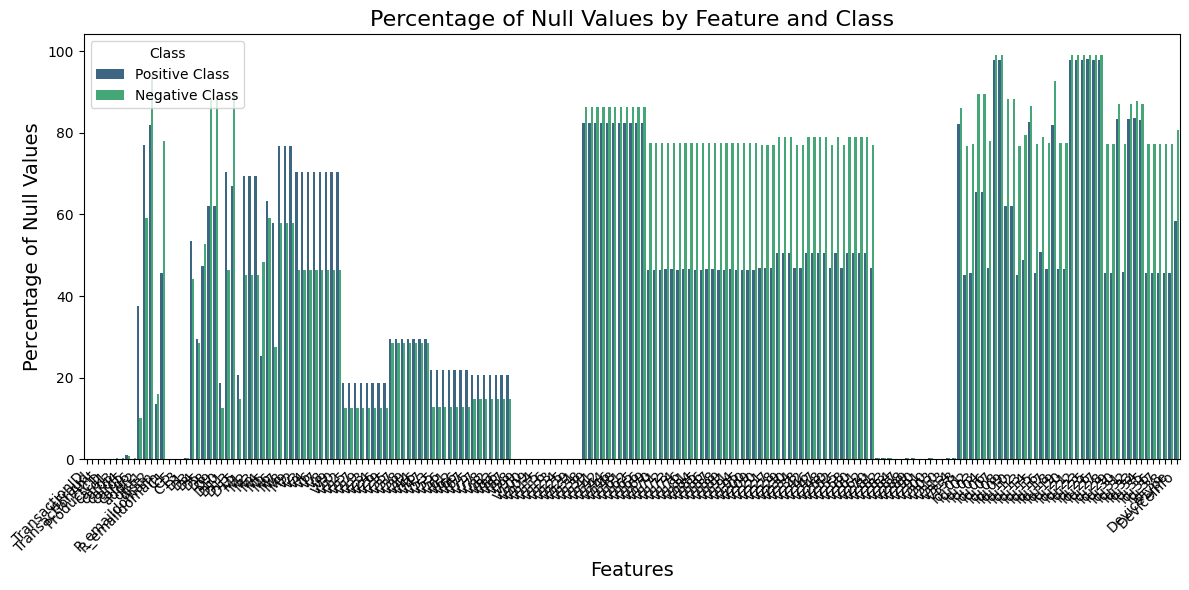

In [24]:
positive_df = train_df[train_df['isFraud'] == 1]
negative_df = train_df[train_df['isFraud'] == 0]

null_percent_positive = positive_df.isnull().mean() * 100
null_percent_negative = negative_df.isnull().mean() * 100

# Create a DataFrame for plotting
null_percent_df = pd.DataFrame({
    'Feature': null_percent_positive.index,
    'Positive Class': null_percent_positive.values,
    'Negative Class': null_percent_negative.values
})

# Melt the DataFrame for seaborn
null_percent_df_melted = null_percent_df.melt(id_vars='Feature', var_name='Class', value_name='Null Percentage')

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Null Percentage', hue='Class', data=null_percent_df_melted, palette='viridis')

# Add labels and title
plt.title('Percentage of Null Values by Feature and Class', fontsize=16)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Percentage of Null Values', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Class')
plt.tight_layout()
plt.show()

If in a category there are a lot of null values and the percentage of null values is similar across both classes, then drop.

In [25]:
high_null_threshold = 25  # Drop columns with >25% null values
similarity_threshold = 5  # Null percentages by class differ by <= 5%

# Identify columns to drop
columns_to_drop = []
for col in train_df.columns:
    if col == 'isFraud':  # Skip the target column
        continue
    if (null_percent_positive[col] > high_null_threshold and
        null_percent_negative[col] > high_null_threshold and
        abs(null_percent_positive[col] - null_percent_negative[col]) <= similarity_threshold):
        columns_to_drop.append(col)

# Drop the identified columns
train_df_cleaned = train_df.drop(columns=columns_to_drop)

# Print the results
print("Columns dropped:", columns_to_drop)
print("Cleaned DataFrame Shape:", train_df_cleaned.shape)

Columns dropped: ['D4', 'M5', 'V35', 'V37', 'V38', 'V39', 'V44', 'V46', 'V47', 'V138', 'V139', 'V141', 'V142', 'V144', 'V146', 'V148', 'V161', 'V162', 'V165', 'V166', 'V338', 'id_07', 'id_08', 'id_14', 'id_21', 'id_22', 'id_23', 'id_25', 'id_26', 'id_27', 'id_30', 'id_32', 'id_33', 'id_34']
Cleaned DataFrame Shape: (590540, 153)


**Null Value Handling Strategy:**

- **Categorical columns:**  
  If null % differs significantly between fraud/non-fraud → Replaces nulls with `"Unknown"`  
  Otherwise → Fills with mode (most frequent category)  

- **Numerical columns:**  
  If `0` **not** present in data → Replaces nulls with `0`  
  If `0` exists → Replaces nulls with median  
  If null % difference >40% → Adds `{column}_isnull` flag (1=was null)  

- **No significant difference:**  
  Categorical → Mode imputation  
  Numerical → Median imputation  

In [26]:
newclass_percentage = 0.2

positive_class = train_df_cleaned[train_df['isFraud'] == 1]
negative_class = train_df_cleaned[train_df['isFraud'] == 0]

null_percent_positive = positive_class.isnull().mean() * 100
null_percent_negative = negative_class.isnull().mean() * 100

# Prepare a list for new flag columns
new_flag_columns = []

# Iterate through each column
for col in train_df_cleaned.columns:
    if col == 'isFraud': 
        continue

    diff = abs(null_percent_positive[col] - null_percent_negative[col])
    max_null = max(null_percent_positive[col], null_percent_negative[col])
    
     # Decision 1: If null% difference is significant (>20%) and nulls are frequent (>5%)
    if diff > newclass_percentage * max_null and max_null > 5:  

        # Case 1A: Handle categorical columns (strings/categories)
        if train_df_cleaned[col].dtype == 'object' or train_df_cleaned[col].dtype.name == 'category':  
            # Replace nulls with "Unknown" (treat missingness as a new category)
            train_df_cleaned[col] = train_df_cleaned[col].fillna("Unknown")  

        # Case 1B: Handle numeric columns
        elif np.issubdtype(train_df_cleaned[col].dtype, np.number):  
            # If 0 is not a valid value, use it for imputation (e.g., for amounts)
            if 0 not in train_df_cleaned[col].unique():  
                train_df_cleaned[col] = train_df_cleaned[col].fillna(0)  
            else:  
                # Otherwise, use median (robust to outliers)
                median_value = train_df_cleaned[col].median()  
                train_df_cleaned[col] = train_df_cleaned[col].fillna(median_value)  

                # Decision 2: If null% difference is VERY significant (>40%), add a null flag
                if diff > 0.4 * max_null:  
                    # Track binary flag (1=was null, 0=not null)
                    new_flag_columns.append(train_df_cleaned[col].isnull().astype(int).rename(f'{col}_isnull'))  

    # Decision 3: If null% difference is NOT significant, use simple imputation
    else:  
        # Categorical: Fill with mode (most frequent category)
        if train_df_cleaned[col].dtype == 'object' or train_df_cleaned[col].dtype.name == 'category':  
            mode_value = train_df_cleaned[col].mode()[0]  
            train_df_cleaned[col] = train_df_cleaned[col].fillna(mode_value)  
        # Numeric: Fill with median
        elif np.issubdtype(train_df_cleaned[col].dtype, np.number):  
            median_value = train_df_cleaned[col].median()  
            train_df_cleaned[col] = train_df_cleaned[col].fillna(median_value)  

# Add all flag columns at once
if new_flag_columns:
    train_df_cleaned = pd.concat([train_df_cleaned] + new_flag_columns, axis=1)

Check that all null values have been successfully removed.

In [27]:
# Print columns with null values and their counts
null_counts = train_df_cleaned.isnull().sum()
print(null_counts[null_counts > 0])

Series([], dtype: int64)


NEW X STRUCTURE:

In [28]:
train_df_cleaned.shape

(590540, 173)

In [29]:
X = train_df_cleaned.drop('isFraud', axis=1)
y = train_df_cleaned['isFraud']

## Encoding Categorical features

From Kaggle's data description, categorical features are grouped as follows:

### Transaction Data

| Feature Type       | Columns                      |
|--------------------|-----------------------------|
| Product Code       | `ProductCD`                 |
| Card Information   | `card1` to `card6`          |
| Address Fields     | `addr1`, `addr2`            |
| Email Domains      | `P_emaildomain`, `R_emaildomain` |
| Transaction Flags  | `M1` to `M9`                |

### Identity Data

| Feature Type       | Columns                      |
|--------------------|-----------------------------|
| Device Information | `DeviceType`, `DeviceInfo`  |
| ID Fields          | `id_12` to `id_38`          |

Encode categorical features

In [30]:
X.shape

(590540, 172)

In [31]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

for column in categorical_cols:
    num_categories = len(X[column].unique())  
    print(f"{column}: {num_categories} categories")

ProductCD: 5 categories
card4: 4 categories
card6: 4 categories
P_emaildomain: 59 categories
R_emaildomain: 61 categories
M1: 3 categories
M2: 3 categories
M3: 3 categories
M4: 4 categories
M6: 3 categories
M7: 3 categories
M8: 3 categories
M9: 3 categories
id_12: 3 categories
id_15: 3 categories
id_16: 3 categories
id_28: 3 categories
id_29: 3 categories
id_31: 131 categories
id_35: 3 categories
id_36: 3 categories
id_37: 3 categories
id_38: 3 categories
DeviceType: 3 categories
DeviceInfo: 1787 categories


Some columns have too many categories, because of this we need to encode values differently depending on the size

Let's first figure out if some columns do not corelate with target value, hence are useless and can be dropped

In [32]:
import pandas as pd
import numpy as np
import scipy.stats as stats

def categorize_categorical_features(X, y, categorical_cols, 
                                  p_threshold=0.05, cramers_threshold=0.1, 
                                  max_onehot=6, max_target=1000):
    """
    Categorizes categorical features into:
    - target_encoding_cols: High-cardinality significant features
    - onehot_cols: Low-cardinality significant features
    - drop_cols: Insignificant or ultra-high-cardinality features
    
    Parameters:
    - X: Features DataFrame
    - y: Target Series
    - categorical_cols: List of categorical columns in X
    - p_threshold: Chi-Square p-value threshold
    - cramers_threshold: Cramér's V effect size threshold
    - max_onehot: Max unique values for one-hot encoding
    - max_target: Max unique values for target encoding
    """
    target_encoding_cols = []
    onehot_cols = []
    drop_cols = []
    
    for col in categorical_cols:
        unique_count = X[col].nunique()
        
        # Skip ultra-high cardinality features
        if unique_count > max_target:
            drop_cols.append(col)
            continue
            
        # Create contingency table
        contingency_table = pd.crosstab(X[col], y)
        
        # Chi-Square Test
        try:
            chi2, p, _, _ = stats.chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
        except:
            p = 1  # Treat as insignificant if test fails
            cramers_v = 0
            
        # Categorize the feature
        if p >= p_threshold or cramers_v < cramers_threshold:
            drop_cols.append(col)
        elif unique_count <= max_onehot:
            onehot_cols.append(col)
        else:
            target_encoding_cols.append(col)
    
    return {
        'target_encoding': target_encoding_cols,
        'onehot': onehot_cols,
        'drop': drop_cols
    }

# Usage example
result = categorize_categorical_features(X, y, categorical_cols)

print("Target Encoding Columns:", result['target_encoding'])
print("One-Hot Encoding Columns:", result['onehot'])
print("Drop Columns:", result['drop'])

Target Encoding Columns: ['R_emaildomain', 'id_31']
One-Hot Encoding Columns: ['ProductCD', 'card6', 'M4', 'M6', 'id_12', 'id_15', 'id_16', 'id_28', 'id_29', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType']
Drop Columns: ['card4', 'P_emaildomain', 'M1', 'M2', 'M3', 'M7', 'M8', 'M9', 'DeviceInfo']


In [33]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

# Get the column lists
target_cols = result['target_encoding']
onehot_cols = result['onehot']
drop_cols = result['drop']

# 1. Drop insignificant columns
X = X.drop(columns=drop_cols)

# 2. Apply One-Hot Encoding to low-cardinality features
if onehot_cols:
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    onehot_encoded = ohe.fit_transform(X[onehot_cols])
    onehot_df = pd.DataFrame(onehot_encoded, 
                            columns=ohe.get_feature_names_out(onehot_cols),
                            index=X.index)
    X = pd.concat([X.drop(columns=onehot_cols), onehot_df], axis=1)

# 3. Apply Target Encoding to high-cardinality features
if target_cols:
    te = TargetEncoder(cols=target_cols)
    X = te.fit_transform(X, y)

print(X.head())

   TransactionID  TransactionAmt  card1  card3  card5  addr2  dist1  dist2  \
0        2987000            68.5  13926  150.0  142.0   87.0   19.0   37.0   
1        2987001            29.0   2755  150.0  102.0   87.0    8.0   37.0   
2        2987002            59.0   4663  150.0  166.0   87.0  287.0   37.0   
3        2987003            50.0  18132  150.0  117.0   87.0    8.0   37.0   
4        2987004            50.0   4497  150.0  102.0   87.0    8.0   37.0   

   R_emaildomain   C1  ...  id_35_T  id_35_Unknown  id_36_T  id_36_Unknown  \
0       0.020819  1.0  ...      0.0            1.0      0.0            1.0   
1       0.020819  1.0  ...      0.0            1.0      0.0            1.0   
2       0.020819  1.0  ...      0.0            1.0      0.0            1.0   
3       0.020819  2.0  ...      0.0            1.0      0.0            1.0   
4       0.020819  1.0  ...      1.0            0.0      0.0            0.0   

   id_37_T  id_37_Unknown  id_38_T  id_38_Unknown  DeviceType_

In [ ]:
X.shape

(590540, 181)

## Scale features

In [35]:
# Find non-numeric columns in your training data
non_numeric_cols = X.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_cols.tolist())

Non-numeric columns: []


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Auto-detect numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Convert all to float to prevent warnings
X[numerical_cols] = X[numerical_cols].astype('float64')

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

X_scaled = pd.DataFrame(
    preprocessor.fit_transform(X),
    columns=numerical_cols + [col for col in X.columns if col not in numerical_cols],
    index=X.index
)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

In [38]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder


def train_models(X_train, y_train):
    # Class weights for imbalance
    fraud_ratio = y_train.mean()
    class_weight = {0: 1, 1: (1 - fraud_ratio)/fraud_ratio}
    
    
    models = {
        'RandomForest': Pipeline([
            ('model', RandomForestClassifier(
                class_weight=class_weight,
                n_jobs=-1,
                random_state=42))
        ]),
        # 'GradientBoosting': Pipeline([
        #     ('model', GradientBoostingClassifier(random_state=42))
        # ]),
    #     'SVM': Pipeline([
    #     ('pca', PCA(n_components=0.95)),  # Keep 95% variance
    #     ('svm', SVC(
    #         class_weight='balanced',
    #         kernel='rbf',
    #         C=1.0,
    #         gamma='scale',
    #         probability=True,
    #         random_state=42))
    # ])
    }
    
    # Train all models
    trained_models = {}
    for name, pipeline in models.items():
        print(f"Training {name}...")
        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline
    return trained_models

In [39]:
def evaluate_models(models, X_test, y_test):
    results = {}
    for name, model in models.items():
        # Get predictions
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Store metrics
        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_prob),
            'average_precision': average_precision_score(y_test, y_prob)
        }
        
        # Print summary
        print(f"\n{name} Performance:")
        print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
        print(f"Avg Precision: {results[name]['average_precision']:.4f}")
        print("Confusion Matrix:")
        print(results[name]['confusion_matrix'])
    
    return results

In [40]:
# 3. Train models
print("\nTraining models...")
trained_models = train_models(X_train, y_train)

# 4. Evaluate models
print("\nEvaluating models...")
results = evaluate_models(trained_models, X_test, y_test)


Training models...
Training RandomForest...

Evaluating models...

RandomForest Performance:
ROC AUC: 0.9348
Avg Precision: 0.7453
Confusion Matrix:
[[170824    139]
 [  3423   2776]]


In [41]:
from joblib import dump

# Save variables
dump(
    {
        'X_train': X_train,
        'y_train': y_train,
        'X_test': X_test,
        'y_test': y_test
    },
    'train_test_data.joblib'
)

dump(trained_models, 'models.joblib')

['models.joblib']